In [25]:
import numpy as np
import tensorflow as tf
import keras
from datetime import datetime
import os
os.makedirs("models", exist_ok=True)

In [26]:
path_to_file = keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
)
print(path_to_file)

with open(path_to_file) as f:
    shakespeare_text = f.read()
print(shakespeare_text[:148])

shakespeare_tensor = tf.constant([shakespeare_text])

/home/jovyan/.keras/datasets/shakespeare.txt
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [27]:
vocab = list(set(shakespeare_text.lower().strip()))
print(vocab)
print(f"vocab size = {len(vocab)}")

['l', ',', '?', 'v', 'd', 'g', ':', 'k', "'", '!', 'h', 'x', '\n', '$', ';', 'a', 'y', 'p', 'c', '-', 'u', 't', 'r', 'f', ' ', 'o', '.', 'q', 'e', 'i', 's', 'z', '3', 'n', 'j', '&', 'm', 'b', 'w']
vocab size = 39


In [28]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(shakespeare_text.lower())
config = tokenizer.get_config()
tokenizer.texts_to_sequences(["hello world", "hello world"])

[[7, 2, 12, 12, 4, 1, 17, 4, 9, 12, 13],
 [7, 2, 12, 12, 4, 1, 17, 4, 9, 12, 13]]

In [29]:
n_tokens = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [30]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
print(f"{encoded[:100]}")

[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13]


# Create Dataset

In [31]:
train_size = dataset_size * 90 // 100
print(f"train_size = {train_size}")

train_size = 1003854


In [32]:
dataset = tf.data.Dataset.from_tensor_slices(encoded)
#dataset = dataset.repeat()
n_steps = 50
dataset = dataset.window(n_steps + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_ds: window_ds.batch(n_steps + 1))

In [33]:
for x in dataset.take(2):
    print(x)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0], shape=(51,), dtype=int64)
tf.Tensor(
[ 5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1  0
 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1  4
  8  0 14], shape=(51,), dtype=int64)


In [34]:
dataset = dataset.batch(128)

In [35]:
for x in dataset.take(1):
    print(x.shape)

(128, 51)


In [36]:
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))

In [37]:
dataset = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
for x, y in dataset.take(1):
    print(f"x = {x.shape}")
    print(f"y = {y.shape}")    

x = (128, 50)
y = (128, 50)


2025-06-02 20:08:32.438210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
transform = lambda x, y: (tf.one_hot(x, depth=n_tokens), y)
dataset = dataset.map(transform)
for x, y in dataset.take(1):
    print(f"x = {x.shape}")
    print(f"y = {y.shape}")

x = (128, 50, 39)
y = (128, 50)


2025-06-02 20:08:32.576898: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Create Models

In [40]:
m1 = keras.Sequential(
    [
        keras.layers.Input(shape=[None, n_tokens]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.Dense(n_tokens, activation="softmax")
    ]
)
m1.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m1.summary()
model = m1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 39)       │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,927 (273.15 KB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
text = "to be "
tokens = tokenizer.texts_to_sequences([text])
inp_tf = tf.constant(tokens)
inp_tf = tf.one_hot(inp_tf, depth=n_tokens)
print(inp_tf.shape)
y = model.predict(inp_tf)
print(y.shape)
y = tf.argmax(y[0,-1])

(1, 6, 39)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 6, 39)


In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
history = m1.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
m1.save("models/shakespeare_gru_1.keras")

Epoch 1/10
7842/7842 - 32s - 4ms/step - loss: 1.9026
Epoch 2/10
7842/7842 - 4s - 457us/step - loss: 1.6962
Epoch 3/10


2025-06-02 20:09:08.428696: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5712130392276371919
2025-06-02 20:09:08.428740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8495146830438278188
2025-06-02 20:09:08.428752: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 18104808730622954760
2025-06-02 20:09:08.428761: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16071758684045944598


KeyboardInterrupt: 

In [ ]:
m2 = keras.Sequential(
    [
        keras.layers.Input(shape=[None, n_tokens]),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.Dense(n_tokens, activation="softmax")
    ]
)
m2.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m2.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
# start_time = time.time.now()
h2 = m2.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
# runtime = time.perf_counter() - start_time
# print(f"Time {runtime:,.0f} seconds.")
m2.save("models/shakespeare_lstm_1.keras")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 128)      │        86,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 39)       │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,047 (355.65 KB)

 Trainable params: 91,047 (355.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7842/7842 - 44s - 6ms/step - loss: 2.0531
Epoch 2/10
7842/7842 - 5s - 644us/step - loss: 1.7582
Epoch 3/10


2025-06-02 18:51:30.259063: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-06-02 18:51:30.259115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15030688198468792457
2025-06-02 18:51:30.259130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10956761685141205067
2025-06-02 18:51:30.259142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6383923000466586468


7842/7842 - 45s - 6ms/step - loss: 1.6652
Epoch 4/10
7842/7842 - 5s - 696us/step - loss: 1.6058
Epoch 5/10


2025-06-02 18:52:20.795759: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12961475734197579845
2025-06-02 18:52:20.795846: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12248384264872389454
2025-06-02 18:52:20.795921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6383923000466586468
2025-06-02 18:52:20.795946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15030688198468792457
2025-06-02 18:52:20.796041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10956761685141205067


7842/7842 - 45s - 6ms/step - loss: 1.5557
Epoch 6/10
7842/7842 - 5s - 664us/step - loss: 1.5393
Epoch 7/10


2025-06-02 18:53:11.454968: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12248384264872389454
2025-06-02 18:53:11.455044: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7651563885489450134
2025-06-02 18:53:11.455068: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12961475734197579845
2025-06-02 18:53:11.455142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15030688198468792457
2025-06-02 18:53:11.455160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10956761685141205067


7842/7842 - 45s - 6ms/step - loss: 1.5015
Epoch 8/10
7842/7842 - 5s - 681us/step - loss: 1.5007
Epoch 9/10


2025-06-02 18:54:02.009227: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12248384264872389454
2025-06-02 18:54:02.009253: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 7651563885489450134
2025-06-02 18:54:02.009260: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12961475734197579845
2025-06-02 18:54:02.009283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6383923000466586468
2025-06-02 18:54:02.009286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15030688198468792457
2025-06-02 18:54:02.009296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10956761685141205067


7842/7842 - 45s - 6ms/step - loss: 1.4681
Epoch 10/10
7842/7842 - 5s - 654us/step - loss: 1.4751


2025-06-02 18:54:52.382431: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12248384264872389454
2025-06-02 18:54:52.382460: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 12961475734197579845
2025-06-02 18:54:52.382485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6383923000466586468
2025-06-02 18:54:52.382491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15030688198468792457
2025-06-02 18:54:52.382501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10956761685141205067


In [ ]:
m3 = keras.Sequential(
        [
                keras.layers.Input(shape=(None, n_tokens)),
                keras.layers.GRU(128, return_sequences=True),
                keras.layers.GRU(128, return_sequences=True),
                keras.layers.Dense(n_tokens, activation="softmax")
                ],
        )
m3.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
m3.summary()
model = m3

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 39)       │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,999 (660.15 KB)

 Trainable params: 168,999 (660.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)
start_time = datetime.now()
history3 = m3.fit(dataset, epochs=10, steps_per_epoch=train_size // 128, callbacks=[early_stopping], verbose=2)
elapsed_time3 = datetime.now() - start_time
print(f"Training completed in {elapsed_time3.total_seconds():.0f} seconds.")
m3.save("models/shakespeare_gru_2.keras")

Epoch 1/10
7842/7842 - 62s - 8ms/step - loss: 1.7734
Epoch 2/10
7842/7842 - 7s - 894us/step - loss: 1.5953
Epoch 3/10


2025-06-02 18:56:01.311851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1514158728039211518
2025-06-02 18:56:01.312014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13292571359239383672
2025-06-02 18:56:01.312045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12256594928107484770


7842/7842 - 63s - 8ms/step - loss: 1.5119
Epoch 4/10
7842/7842 - 7s - 871us/step - loss: 1.4989
Epoch 5/10


2025-06-02 18:57:10.979437: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 223074015065271011
2025-06-02 18:57:10.979519: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14478443630390573037
2025-06-02 18:57:10.979542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1514158728039211518
2025-06-02 18:57:10.979614: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3330582164692251952


7842/7842 - 63s - 8ms/step - loss: 1.4480
Epoch 6/10
7842/7842 - 7s - 829us/step - loss: 1.4541
Epoch 7/10


2025-06-02 18:58:20.175924: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3330582164692251952
2025-06-02 18:58:20.176008: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 223074015065271011
2025-06-02 18:58:20.176070: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14478443630390573037


7842/7842 - 61s - 8ms/step - loss: 1.4148
Epoch 8/10
7842/7842 - 7s - 943us/step - loss: 1.4271
Epoch 9/10


2025-06-02 18:59:28.752309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1514158728039211518
2025-06-02 18:59:28.752390: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3330582164692251952
2025-06-02 18:59:28.752411: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14478443630390573037
2025-06-02 18:59:28.752432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/gru_1_1/Shape/_4]]


7842/7842 - 61s - 8ms/step - loss: 1.3935
Epoch 10/10
7842/7842 - 7s - 869us/step - loss: 1.4090
Training completed in 344 seconds.


2025-06-02 19:00:36.825667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1514158728039211518
2025-06-02 19:00:36.825769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13292571359239383672
2025-06-02 19:00:36.825809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12256594928107484770


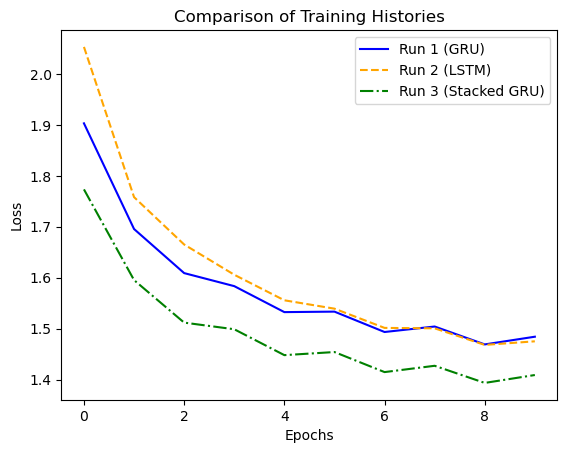

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values from the three history objects
loss1 = history.history['loss']
loss2 = h2.history['loss']
loss3 = history3.history['loss']

# Plot the training losses
plt.plot(loss1, label="Run 1 (GRU)", linestyle='-', color='blue')
plt.plot(loss2, label="Run 2 (LSTM)", linestyle='--', color='orange')
plt.plot(loss3, label="Run 3 (Stacked GRU)", linestyle='-.', color='green')

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Training Histories")
plt.legend()

# Display the plot
plt.show()